# Response Clustering

1. [Mooc tags dataset](#1)  
   1.1 [Word2Vec](#1.1)  
   1.2 [Fasttext](#1.2)  
   1.3 [Visualization](#1.3)   
2. [Reflection questions dataset](#2)  
   2.1 [Processing data](#2.1)   
   2.2 [Perform LDA and NMF](#2.2)  
   2.3 [Visualization](#2.3)  
3. [Hypothesis dataset](#3)

In [459]:
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet, stopwords
import pandas as pd
import pyLDAvis
import numpy as np
import seaborn as sns
import operator
import squarify
import matplotlib.pyplot as plt
import re
import gensim
import time
import networkx as nx
import requests
import csv
import json
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import Jitter, Range1d, HoverTool, LabelSet, Label
from bokeh.layouts import column
from bokeh.sampledata.autompg import autompg as df
from bokeh.io import output_notebook
from collections import OrderedDict

In [3]:
def set_size(SIZE=20):
    """
     This method sets size for labels, legends... of matplotlib.pyplot
    """

    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)

# 1) Mooc tags dataset
<a id='1'></a>


In [340]:
mooc_tags = pd.read_csv("data/mooc_tags.txt" ,delimiter="\t")
mooc_tags.columns = ['text']
mooc_tags.head(10)

text
0                        area
1               living things
2  plants: growth and changes
3  animals: growth and change
4                  structures
5      american music history
6                        soil
7                          pe
8                    anathomy
9              best practices

In [341]:
mooc_tags.describe()

text
count    2096
unique   2094
top     tesol
freq        2

There are 2096 tags in the database

First, depend on the dataset and on the purpose, we decide what to be removed.
Need to see some samples in the dataset and try to detect some special things to be removed.
For instant, we remove urls, hashtag, @, numbers, punctuations.

In [342]:
def standardize_text(df, text_field):
    
    """ 
        Input:
            - df: data's dataframe
            - text_field: column that we want to standardize
        Output:
            - dataframe contains `standardized` column
    """
    
    urls_re = r'http\S+' #urls
    ht_re = r'#\S+'      #hashtags
    at_re = r'@\S+'      #@
    nb_re = " \d+"       #numbers

    punctuations = ["/","(",")","\\","|", ":",",",";",".","?", "!", "[", "]", "{","}"]
    
    new_text = []
    for text in df[text_field]:
        
        text = text.replace("\\n"," ").replace("\n", " ").replace("-"," ").replace("_"," ").replace('amp'," ").replace('co', " ")
        
        for x in punctuations:
            text = text.replace(x , " ")
            
        text = re.sub(urls_re , " ", text)
        text = re.sub(ht_re   , " ", text)
        text = re.sub(at_re   , " ", text)
        text = re.sub(nb_re   , " ", text)
        
        text = text.replace("http"," ")
        
        new_text.append(text.lower())
    
    df['standardized_' + text_field] = new_text
    return df



In [343]:
mooc_tags = standardize_text(mooc_tags, "text")
mooc_tags.head(10)

text           standardized_text
0                        area                        area
1               living things               living things
2  plants: growth and changes  plants  growth and changes
3  animals: growth and change  animals  growth and change
4                  structures                  structures
5      american music history      american music history
6                        soil                        soil
7                          pe                          pe
8                    anathomy                    anathomy
9              best practices              best practices

Secondly, we need to choose `indexing terms` for our TFIDF matrix. Step by step:
* Tokenization: splitting the text into words (actually a NLP issue, think about `credit card`...)
* Stopwords removing: term explicitely to be excluded from indexing (the, a, be, this, to, or...). What happened if we have a text `to be or not to be` ?
* Lemmatization: process of reducing words. For instant: eats, eating, ate, eaten => eat. It helps reduces index size / increases information value of each indexing term.

In [344]:
def get_wordnet_pos(treebank_tag):
    """Map ['NN', 'NNS', 'NNP', 'NNPS'] to NOUN....."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def processing(sentence):
    
    tokenizer = RegexpTokenizer(r'\w+')
    
    "Tokenization"
    sentence = tokenizer.tokenize(sentence)
    
    "Lemmatization"
    lemmatiser = WordNetLemmatizer()
    tokens_pos = pos_tag(sentence)
    tokens_pos = [(w,get_wordnet_pos(p)) for (w,p) in tokens_pos]
    
    sentence = [lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]
    
    "Stopwords removing"
    stop = stopwords.words('english')
    sentence = [x for x in sentence if x not in stop ]
    
    return ' '.join(sentence)

def processing_text(df, text_field):
    new_text = []
    for text in df[text_field]:
        new_text.append(processing(text))
    df['processed_text'] = new_text
    return df

In [345]:
mooc_tags = processing_text(mooc_tags, 'standardized_text')
mooc_tags.head(10)

text           standardized_text  \
0                        area                        area   
1               living things               living things   
2  plants: growth and changes  plants  growth and changes   
3  animals: growth and change  animals  growth and change   
4                  structures                  structures   
5      american music history      american music history   
6                        soil                        soil   
7                          pe                          pe   
8                    anathomy                    anathomy   
9              best practices              best practices   

           processed_text  
0                    area  
1              live thing  
2     plant growth change  
3    animal growth change  
4               structure  
5  american music history  
6                    soil  
7                      pe  
8                anathomy  
9           best practice

In [346]:
mooc_tags['length'] = mooc_tags['processed_text'].apply(lambda row : len(row.split()))
mooc_tags.head(10)

text           standardized_text  \
0                        area                        area   
1               living things               living things   
2  plants: growth and changes  plants  growth and changes   
3  animals: growth and change  animals  growth and change   
4                  structures                  structures   
5      american music history      american music history   
6                        soil                        soil   
7                          pe                          pe   
8                    anathomy                    anathomy   
9              best practices              best practices   

           processed_text  length  
0                    area       1  
1              live thing       2  
2     plant growth change       3  
3    animal growth change       3  
4               structure       1  
5  american music history       3  
6                    soil       1  
7                      pe       1  
8                anathomy       1  
9           best practice       2

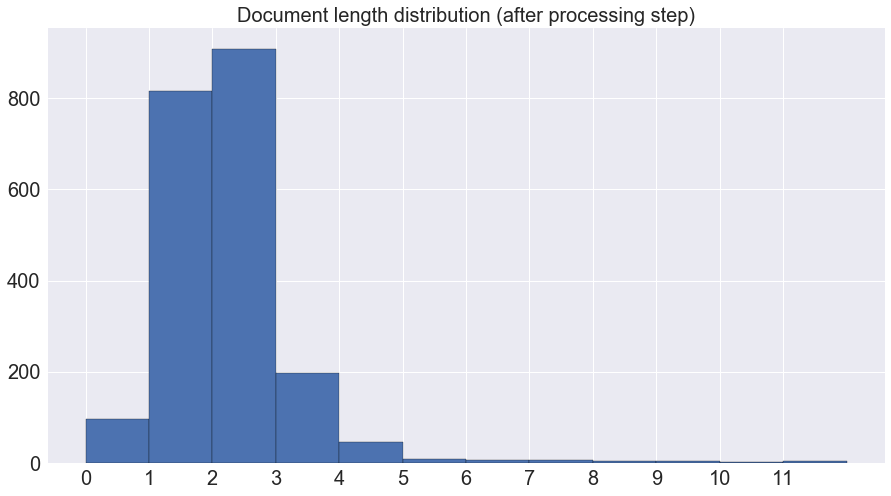

In [333]:
set_size()
plt.subplots(figsize=(15,8))
mooc_tags['length'].hist(bins=mooc_tags['length'].max(),edgecolor='black')
plt.xticks(list(range(0,mooc_tags['length'].max())))
plt.title('Document length distribution (after processing step)')
plt.show()

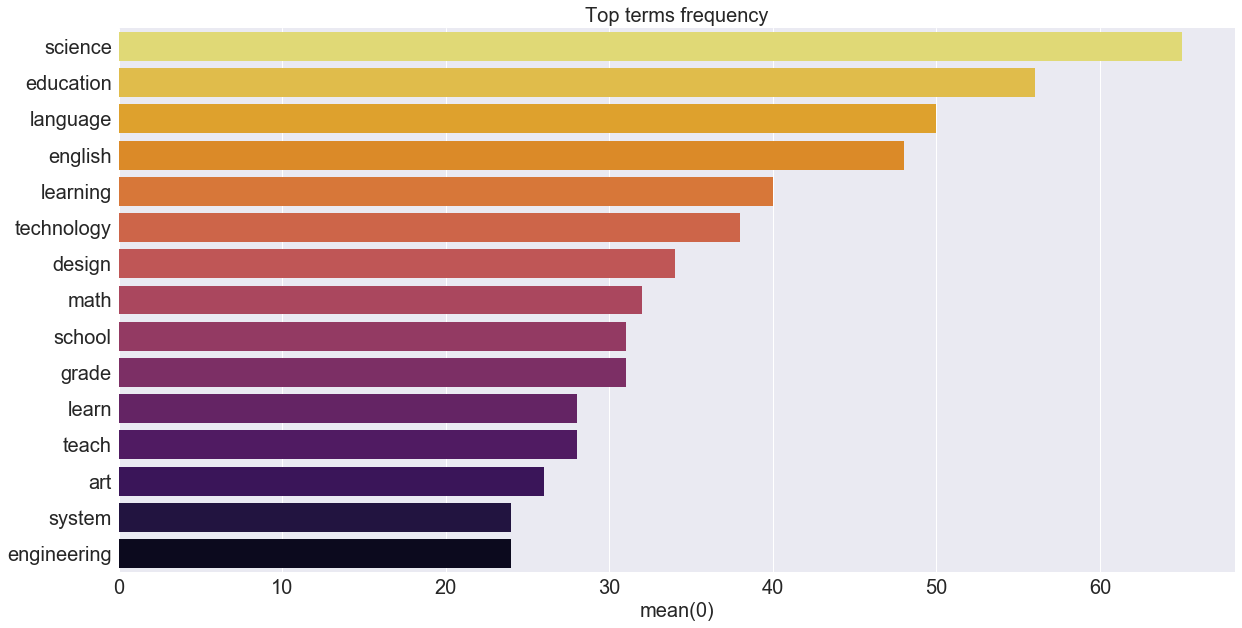

In [334]:
set_size()

terms = []

for text in mooc_tags['processed_text']:
    for term in text.split():
        terms.append(term)
        
plt1 = pd.Series(terms).value_counts().sort_values(ascending=False)[:15].to_frame()
sns.barplot(plt1[0],plt1.index,palette=sns.color_palette('inferno_r',15))
plt.title('Top terms frequency')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

## 1.1) word2vec 
<a id='1.1'></a>

### 1.1.1) Build your own word2vec model

In [337]:
def build_word2vec(df, text_field):
    """
        Training word2vec model with your own dataset and then visualize it into 2 first PCAs
    """
    sentences = [x.split() for x in np.array(df[text_field])]

    model = Word2Vec(sentences, min_count=3)

    X = model[model.wv.vocab]
    X *= 100000000
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)

    plt.figure(figsize=(20,20))
    set_size()
    plt.scatter(result[:, 0], result[:, 1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()

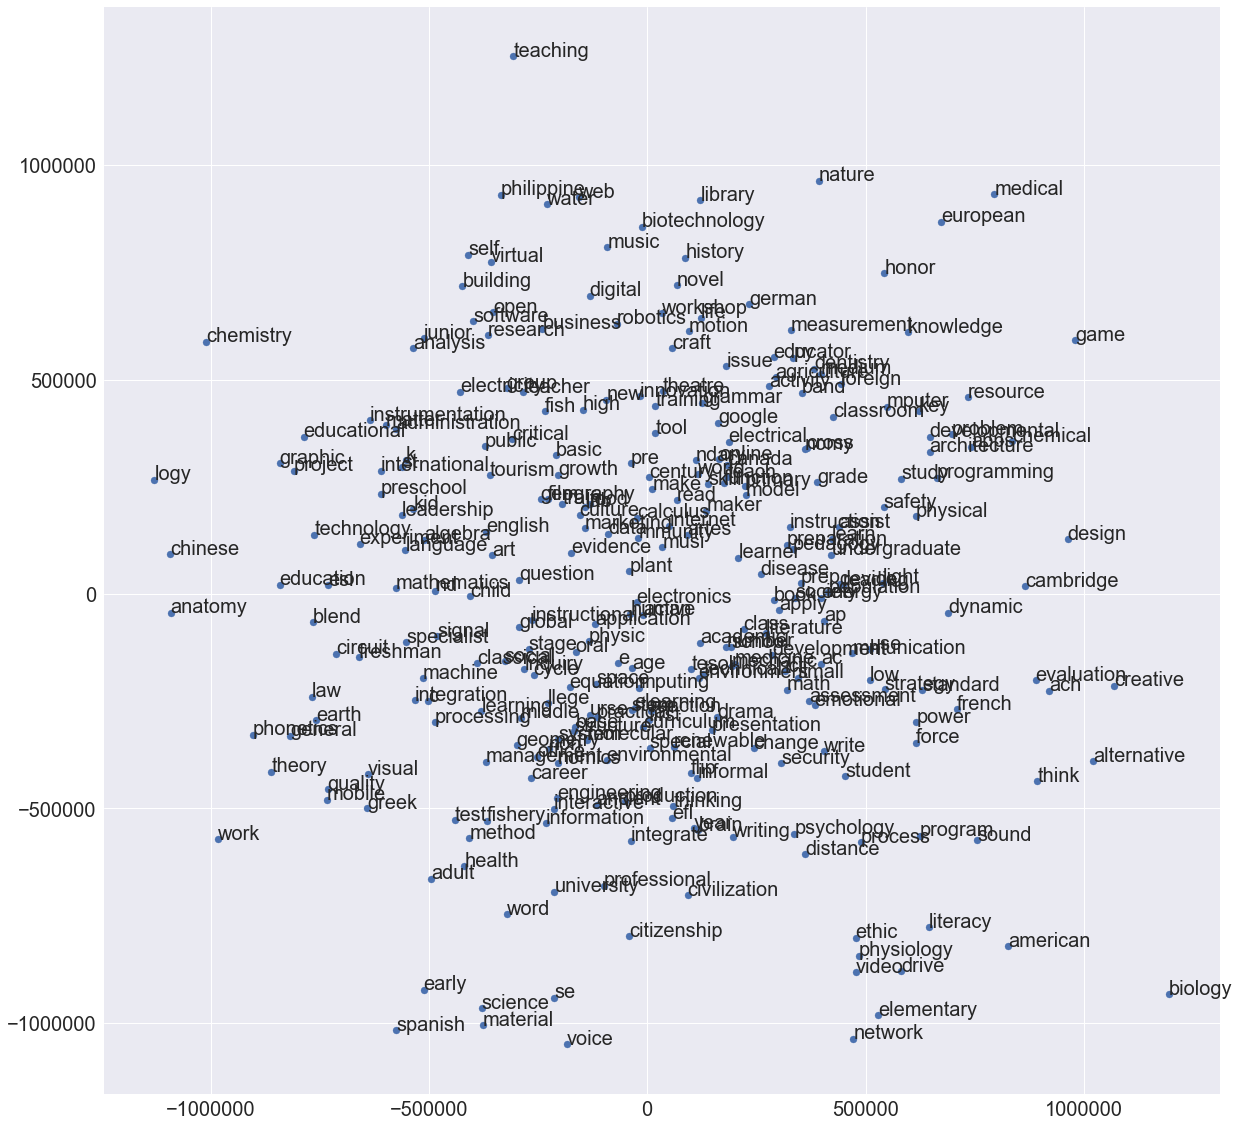

In [347]:
build_word2vec(mooc_tags, 'processed_text')

This method seems to be fail, the reason is our dataset is too small...

### 1.1.2) Word2Vec using a pre-train model of Google

In [348]:
"""
    Download word2vec pre-trained model at : "https://code.google.com/archive/p/word2vec/"
"""

word2vec_path = "/Users/Cescnghia/Documents/dataset/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [349]:
word2vec['king'].shape

(300,)

Each word is depocomsed into 300 dimensions

In [350]:
word2vec.most_similar(positive=['queen', 'men'], negative=['king'], topn=1)

[('women', 0.7216066122055054)]

Queen - King + Man = Women

In [351]:
word2vec.most_similar('england', topn=10)

[('liverpool', 0.7172455787658691),
 ('chelsea', 0.7060471177101135),
 ('fulham', 0.7020782232284546),
 ('tottenham', 0.6907042860984802),
 ('rooney', 0.6863133907318115),
 ('man_utd', 0.6844729781150818),
 ('torres', 0.6763710379600525),
 ('ronaldo', 0.6757338643074036),
 ('spain', 0.6740614175796509),
 ('gerrard', 0.6709044575691223)]

### 2.1.3) Word2Vec + K means

The simple idea is take all 1-gram tags, transform it into vector and cluster it.

In [370]:
word2vec_df = mooc_tags[mooc_tags['length'] == 1]
print('There are',len(word2vec_df),'1-gram tags.')

There are 815 1-gram tags.


For assigning a vector to word using pre-train model of google, we will have a problem with words(in our dataset) that are not contained in the word2vec model of google. For instance, I will take only the tags that are in the word2vec model of google.

In [356]:
word2vec_df['meaningful_word2vec'] = word2vec_df['processed_text'].apply(lambda x : x in word2vec)
word2vec_df = word2vec_df[word2vec_df['meaningful_word2vec']==True]
word2vec_df = word2vec_df.reset_index().drop('index', 1)
word2vec_df = word2vec_df[['text', 'processed_text']].copy()
word2vec_df.head(10)

text processed_text
0         area           area
1   structures      structure
2         soil           soil
3           pe             pe
4          css             cs
5     decimals        decimal
6   humanities       humanity
7  engineering    engineering
8  immigration    immigration
9    elearning      elearning

In [357]:
def word2vector(word):
    return word2vec[word]

In [358]:
word2vec_df['word2vec'] = word2vec_df['processed_text'].apply(word2vector)
word2vec_df.head(10)

text processed_text  \
0         area           area   
1   structures      structure   
2         soil           soil   
3           pe             pe   
4          css             cs   
5     decimals        decimal   
6   humanities       humanity   
7  engineering    engineering   
8  immigration    immigration   
9    elearning      elearning   

                                            word2vec  
0  [-0.072265625, 0.052490234, 0.053955078, -0.05...  
1  [0.032226562, 0.022338867, -0.059814453, 0.021...  
2  [-0.14941406, 0.484375, 0.34765625, -0.0126342...  
3  [0.0018234253, 0.22363281, 0.10644531, 0.23925...  
4  [-0.16992188, 0.16699219, 0.265625, -0.0061035...  
5  [-0.045898438, -0.15625, 0.17089844, 0.1601562...  
6  [0.19335938, 0.23730469, 0.46679688, 0.1523437...  
7  [-0.19628906, 0.09716797, 0.12792969, 0.093261...  
8  [-0.11621094, 0.13574219, 0.13671875, 0.142578...  
9  [0.075683594, -0.20214844, -0.11376953, 0.1396...

In [359]:
print('There are',len(word2vec_df),'one gram meaningful')

There are 675 one gram meaningful


In [361]:
"Data preparation for K-Means algorithm"

vocab_word2vec = np.array(word2vec_df['processed_text'])

X_word2vec = []
for x in word2vec_df['word2vec']:
    X_word2vec.append(list(x))

In [362]:
"k-means algorithm"

def k_means(k, X, vocab, seed):
    """
        Input:
            - k : K cluster
            - X : List of words' vectors
            - vocab : labels corresponds to word
            - seed : set random seed 
            
        Output:
            - labels : cluster assignment for words
            - centers: center of K cluster
            - clusters: a dictionary key = cluster, value = list of words within cluster
    """

    kmeans = KMeans(n_clusters=k, random_state=seed).fit(X)
    labels = kmeans.labels_
    centers= kmeans.cluster_centers_
    
    "A dictionary KEY: cluster i, VALUE: ['math','calculus'...]"
    clusters = {}

    for index, label in enumerate(labels):
        if label in clusters:
            temp = clusters[label]
            temp.append(index)
            clusters[label] = temp
        else:
            clusters[label] = [index]
    """
    
    """     
    return labels, centers, clusters

In [363]:
labels_w2v, centers_w2v, clusters_w2v = \
            k_means(k=20, X=X_word2vec, vocab=vocab_word2vec, seed=100)

In [368]:
def print_cluster(k, dict_cluster, vocab):
    for key in range(k):
        string = ''
        indexes = dict_cluster[key]
        print('Cluster number: ',key+1)
    
        for index in indexes:
            string += vocab[index]+', '
        print('[', string, ']')
        print('\n')

In [369]:
print_cluster(20, clusters_w2v, vocab_word2vec)

Cluster number:  1
[ spreadsheet, graph, data, analysis, diagram, algorithm, applet, map, database,  ]


Cluster number:  2
[ rhino, aurora, volcano, python, earthquake, tsunami, disease, bird, specie, lake, mammal, fish,  ]


Cluster number:  3
[ gt, hiv, tb, std, shakespeare, esl, lego, phy, logy, philippine, poland, fea, cad, ict, ib, educat, jk, sk, efi, k, drupal, gmail, l, roman, greek, sla, uae, ipads, eca, istanbul, lm, eal, ding, quebec, hebrew, google, dna, ipads, c, ding, ell, phd, rpgs, dis, c, tbl, asd, cpm, twitter, china, adhd, k, roman, christian, html5, vietnamese, maori, entr, ec, p, greek, tecnology, romanian, u, prac, skype, facebook, l2, cad, java, acl, e, valores, alice, brasil, diseño,  ]


Cluster number:  4
[ electronics, gift, reading, health, parent, nutrition, internet, preschool, education, pharmacy, adult, hospitality, teenager, nursing, mechanic, car, administrator, automobile, educator, smartboard, book, shire, bible, dental, moodle, age, training, mobil

## 1.2) Fasttext 
<a id='1.2'></a>

### 1.2.1) K means

In [4]:
"Download pre-trained model at https://fasttext.cc/docs/en/crawl-vectors.html"

fasttext = gensim.models.KeyedVectors.load_word2vec_format("/Users/Cescnghia/Documents/dataset/wiki.en/wiki.en.vec")

In [375]:
"""
    Since fasttext is a pre-trained model, we have to remove terms in our dataset that are not included
    in the fasttext model
"""

fasttext_df = mooc_tags[mooc_tags['length'] == 1]
fasttext_df['meaningful_fasttext'] = fasttext_df['processed_text'].apply(lambda x : x in fasttext)
fasttext_df = fasttext_df[fasttext_df['meaningful_fasttext']==True]
fasttext_df = fasttext_df.drop_duplicates(subset='processed_text', keep='first', inplace=False)
fasttext_df = fasttext_df.reset_index().drop('index', 1)
fasttext_df = fasttext_df[['text', 'processed_text']].copy()
fasttext_df.head(10)

text processed_text
0         area           area
1   structures      structure
2         soil           soil
3           pe             pe
4          css             cs
5     decimals        decimal
6   humanities       humanity
7  engineering    engineering
8  immigration    immigration
9    elearning      elearning

In [376]:
fasttext_df['fasttext'] = fasttext_df['processed_text'].apply(lambda x : fasttext[x])
fasttext_df.head()

text processed_text  \
0        area           area   
1  structures      structure   
2        soil           soil   
3          pe             pe   
4         css             cs   

                                            fasttext  
0  [-0.17799, -0.26128, 0.31562, 0.12159, -0.3232...  
1  [-0.037278, -0.031467, 0.036801, 0.42904, -0.1...  
2  [-0.25541, -0.17983, -0.12814, 0.14014, -0.362...  
3  [-0.086042, 0.13271, 0.0097988, 0.13944, -0.02...  
4  [0.19479, -0.32558, 0.09338, -0.050811, 0.2083...

In [377]:
def export_fasttext_coordinate(df):
    """
        Export fasttext coordinate for visualization on https://www.tensorflow.org/programmers_guide/embedding
    """
    array = np.zeros((len(df), 300))

    for i in range (len(df)):
        array[i,:] = df.iloc[i]['fasttext']

    cols = [str(i)+'aa' for i in range (300)]
    
    for ind, i in enumerate(cols):
        df[i] = array[:,ind]

    df.to_csv("data/fasttext.tsv", sep='\t', columns=cols, index= False)
    df.to_csv("data/label.tsv", sep='\t', columns=['text'], index= False)

In [378]:
"Data preparation for clustering"

vocab_fasttext = np.array(fasttext_df['processed_text'])

X_fasttext = []
for x in fasttext_df['fasttext']:
    X_fasttext.append(list(x))

In [379]:
labels_fasttext, centers_fasttext, clusters_fasttext = \
            k_means(k=20, X=X_fasttext, vocab=vocab_fasttext, seed=100)

In [380]:
print_cluster(20, clusters_fasttext, vocab_fasttext)

Cluster number:  1
[ pe, reading, speak, sat, gi, write, sing, english, debate, ng, bible, letter, hindi, latin, masen, llege, listen, ding, hebrew, bansho, ell, dis, oking, maori, spell, français, gu, ach, kin, arabic, ako, wananga, tok, li, slang, speech, heba,  ]


Cluster number:  2
[ science, argumentation, astronomy, literature, mathematics, logy, psychology, holistic, experiential, spirituality, metaphysics, mysticism, transdisciplinary, geography, sociology, logic, epistemology, andragogy, university, religion, pedagogy, theology, phd, magnetism, interdisciplinarity, interdisciplinary, naturalist, anthropology, civilization, moral, transdisciplinarity, philosophy, museology, prehistory, pyschology,  ]


Cluster number:  3
[ area, history, network, steam, season, city, flight, force, poland, asia, urban, car, rhino, automobile, weather, weld, jk, k, draw, shire, wiris, l, boston, aurora, roman, uae, first, uk, medy, india, isarel, quebec, c, kzjl, garden, québec, daily, tbl, prb

# 1.3) Visualization
<a id='1.3'></a>

### 1.3.1) t-SNE then Clustering

In [390]:
def tsne(perplexity, X):
     
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', method='exact',n_iter=2000, random_state=259)
    new_X = tsne_model.fit_transform(X)

    return new_X

def generating_k_colors(K):
    "Generate k random colors"
    r = lambda: np.random.randint(0,255)

    colors = ['#%02X%02X%02X' % (r(),r(),r()) for x in range(K)]
    
    return colors


def TSNE_visualisation_word(k, new_X, vocab, labels_kmeans):
    
    "Transform tuple X into x and y coordinates"
    x = []
    y = []

    for tup in new_X:
        x.append(tup[0])
        y.append(tup[1])
        
    "Generate k random colors"
    cluster_colors = generating_k_colors(K)
    


    set_size()
    plt.figure(figsize=(20, 20))
    axes = plt.gca()
    axes.set_xlim([-50,40])
    axes.set_ylim([-40,40])

    for i in range(len(x)):
        plt.scatter(x[i],y[i], c=cluster_colors[labels_kmeans[i]])
           
        if (i % 3 != 0):
            plt.annotate(vocab[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom'
                    )
        
    plt.show()
    

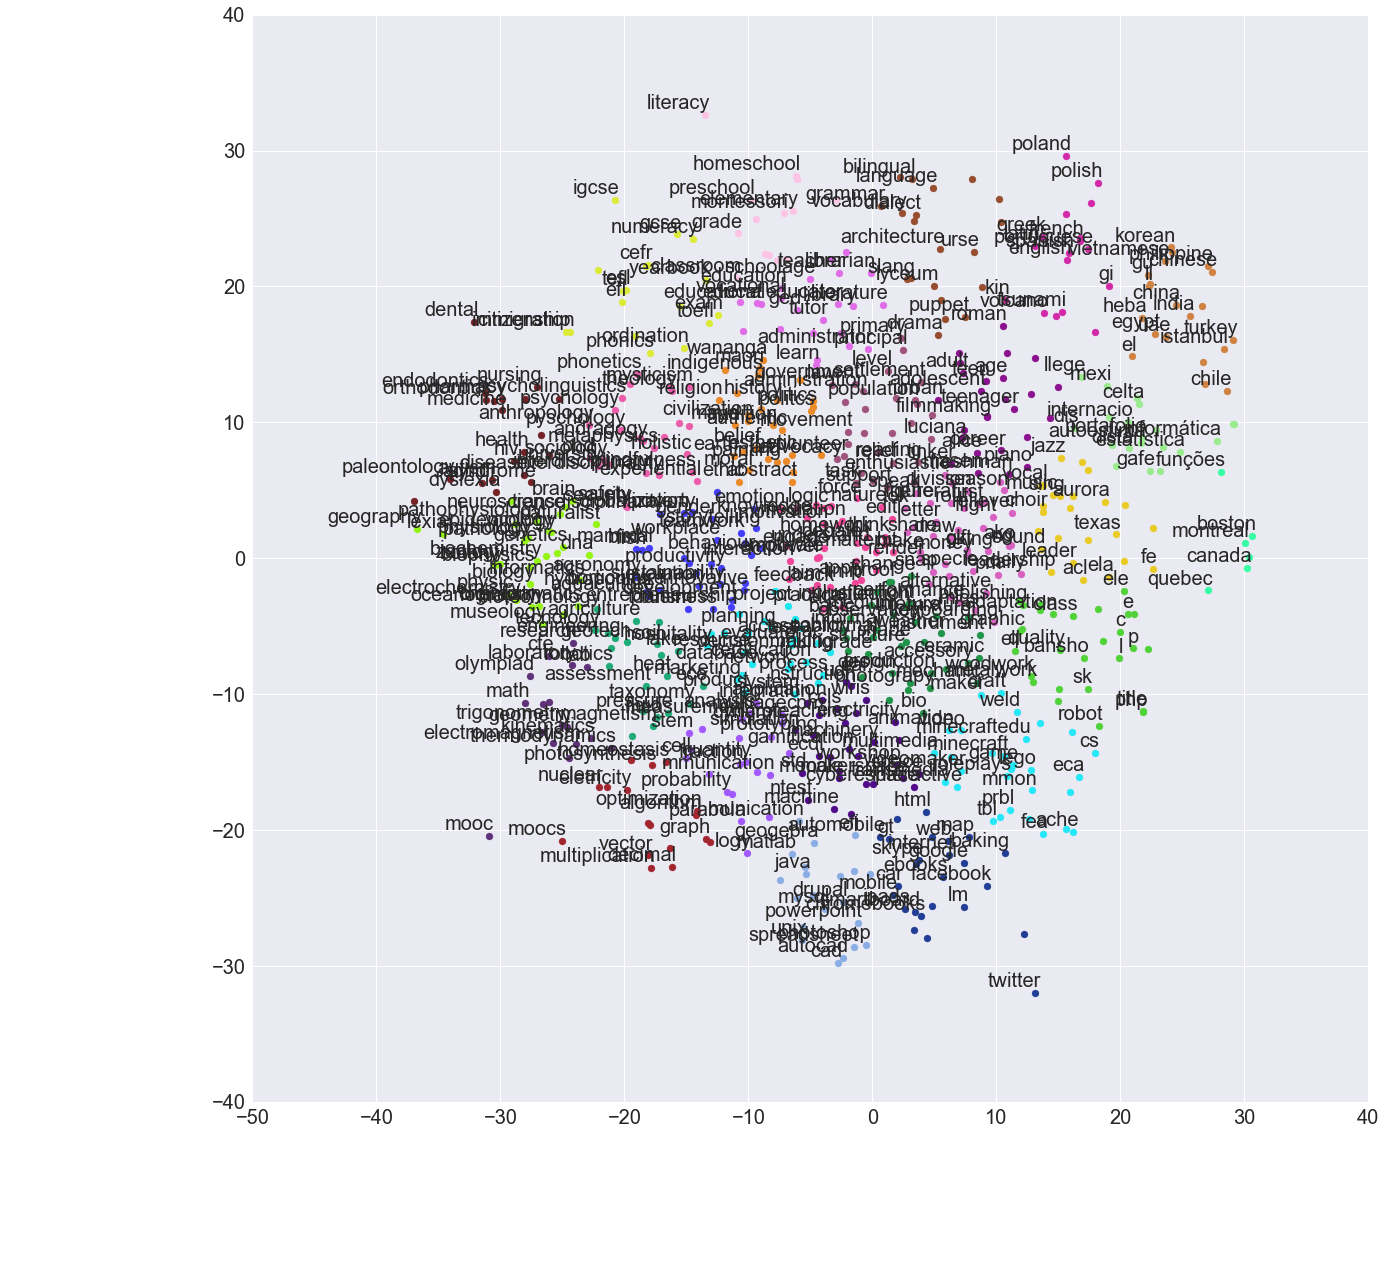

In [404]:
K = 30

"TSNE Algorithm"

TSNE_X_fasttext = tsne(perplexity=30, X=X_fasttext)

"Run k-means"

labels_fasttext_tsne, centers_fasttext_tsne, clusters_fasttext_tsne = \
                            k_means(K, TSNE_X_fasttext, vocab_fasttext, 200)
    
TSNE_visualisation_word(K, TSNE_X_fasttext, vocab_fasttext, labels_fasttext_tsne)

In [393]:
def bokeh_visualization(new_X, vocab, cluster, k):
    output_notebook()
    
    x = []
    y = []

    for tup in new_X:
        x.append(tup[0])
        y.append(tup[1])
    
    "Generate k random colors"
    r = lambda: np.random.randint(0,255)
    colors_choices = ['#%02X%02X%02X' % (r(),r(),r()) for x in range(k)]
    
    colors = [colors_choices[r] for r in cluster]
    source = ColumnDataSource(
        data=dict(
                    x=x,
                    y=y,
                    label=vocab
                 )
    )
    TOOLS="pan,wheel_zoom,box_zoom,reset,hover,previewsave"
    p = figure(title="",plot_width=800, plot_height=800, tools=TOOLS)
    p.circle('x', 'y', color=colors, size=7, source=source)
    
    hover =p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([("word", "@label"),])
    p.x_range = Range1d(-40, 40)
    p.y_range = Range1d(-40, 40)
    output_notebook()
    #output_file(name+".html")
    show(p)

In [396]:
bokeh_visualization(TSNE_X_fasttext, vocab_fasttext, labels_fasttext_tsne, K)

Loading BokehJS ...

Loading BokehJS ...

In [278]:
"""
    ALL CODES IN THIS CELL ARE SERVING FOR CREATING A GRAPH INPUT FOR GEPHI
"""

"Create a graph"

G = nx.Graph()

"Weight between words within cluster"
for i in range(K):
    df = fasttext_df[fasttext_df['cluster']==i]
    representative = df[df['representative_cluster']==True]
    representative_name = representative['processed_text'].to_string().split()[1]
    G.add_node(representative_name, typ='representative')
    G.node[representative_name]['x'] = float(representative['x'])
    G.node[representative_name]['y'] = float(representative['y'])
    for ind, row in df.iterrows():
        word = row['processed_text']
        w = row['distance_to_cluster_center']
        if (word != representative_name):
            G.add_node(word, typ='node')
            G.node[word]['x'] = float(row['x'])
            G.node[word]['y'] = float(row['y'])
            G.add_edge(word, representative_name, weight=float(1/w))
            
"Weight between clusters"

representatives = fasttext_df[fasttext_df['representative_cluster']==True]

while(len(representatives) > 1):
    "Take the first representative of dataframe"
    representative = representatives.iloc[0]
    
    "Remove this representative out of dataframe"
    next_representatives = representatives[representatives.processed_text != representative['processed_text']]
    
    "Compute distance with others representatives"
    coord = np.array([representative['x'], representative['y']])
    for ind, row in next_representatives.iterrows():
        c = np.array([row['x'], row['y']])
        distance = np.sum((coord - c) ** 2)
        G.add_edge(representative['processed_text'], row['processed_text'], weight=float(1/distance))
          
    representatives = next_representatives
    
"Store in disk"

"Graph"
nx.write_graphml(G,"data/cluster.graphml")

### 1.3.2 Using ConceptNet to find concept for each cluster

In [408]:
"""
    An example of conceptnet.io
"""

test = 'french'

obj = requests.get('http://api.conceptnet.io/c/en/' + test).json()['edges']
for i in range(len(obj)):
    if obj[i]['surfaceText']:# and 'is a type of' in obj[i]['surfaceText']:
        print(obj[i]['surfaceText'])

[[French]] is [[a language]]
[[Français]] is a translation of [[French]]
[[Français]] is a translation of [[French]]
[[language]] is related to [[french]]
[[French]] is used in the region of [[France]]
[[Anglo-French]] is a type of [[French]]
[[Canadian French]] is a type of [[French]]
[[French]] is [[a human language]]
[[French]] is a type of [[Romance]]
[[Langue d oc]] is a type of [[French]]
[[Langue d oil]] is a type of [[French]]
[[Norman-French]] is a type of [[French]]
[[Old French]] is a type of [[French]]
[[Walloon]] is a type of [[French]]


In [ ]:
"Assign a cluster to each word base on K means algo"

fasttext_df['cluster'] = labels_fasttext_tsne
fasttext_df['cluster_center'] = fasttext_df['cluster'].apply(lambda x : centers_fasttext_tsne[x])

"Distance of this words to the cluster center"

x = []
y = []
for tup in TSNE_X_fasttext:
    x.append(tup[0])
    y.append(tup[1])
fasttext_df['x'] = x
fasttext_df['y'] = y

def distance_to_cluster_center(row):
    return np.sum(([row['x'], row['y']] - row['cluster_center']) ** 2)

fasttext_df['distance_to_cluster_center'] = fasttext_df \
                                          .apply(distance_to_cluster_center, axis=1)

"Find the center word for each cluster"

has_representative = K*[False]
min_dist = fasttext_df.groupby('cluster')['distance_to_cluster_center'].min()
def find_representative (row):
    cluster = row['cluster']
    if (has_representative[cluster]):
        return False
    else:
        has_representative[cluster] = (min_dist[cluster] == row['distance_to_cluster_center'])
        return has_representative[cluster]
    
fasttext_df['representative_cluster'] = fasttext_df.apply(find_representative, axis=1)

In [399]:
"detect if an indefinite article presents and transform `a programming language` to `programming language`"

def remove_articles(sentence):
    tokens = sentence.split()
    if tokens[0] == 'a':
        return sentence[2:]
    elif tokens[0] == 'an':
        return sentence[3:]
    else:
        return sentence

In [412]:
"Return a list of n related words of a given word"

def related_words(word, n):
    result = []
    obj = requests.get('http://api.conceptnet.io/c/en/' + word).json()['edges']
    n = min(n, len(obj))
    obj = obj[:n]
    for i in range(n):
        response = obj[i]['surfaceText']

        if response: #and ('is a type of' in response or 'is related to' in response) :
            if response.index('[') == 0 :
                tokens = response.split(']]')
                first = tokens[0].split('[[')[1]
                last  = tokens[1].split('[[')[1]
                first = remove_articles(first).lower()
                last  = remove_articles(last).lower()
                if word in first :
                    result.append(last)
                elif word in last :
                    result.append(first)
    return list(set(result))

In [417]:
fasttext_df['related_words' ] = fasttext_df['processed_text'].apply(lambda x : related_words(x, 20))

In [418]:
fasttext_df.head()

text processed_text  \
0        area           area   
1  structures      structure   
2        soil           soil   
3          pe             pe   
4         css             cs   

                                            fasttext  cluster  \
0  [-0.17799, -0.26128, 0.31562, 0.12159, -0.3232...       15   
1  [-0.037278, -0.031467, 0.036801, 0.42904, -0.1...       21   
2  [-0.25541, -0.17983, -0.12814, 0.14014, -0.362...       10   
3  [-0.086042, 0.13271, 0.0097988, 0.13944, -0.02...       19   
4  [0.19479, -0.32558, 0.09338, -0.050811, 0.2083...        5   

                                       related_words               concept  
0  [region, place, room, acreage, department, str...              military  
1  [area, body, altar, ball, column, blade, aster...              clothing  
2  [ground, clunch, fuller's earth, gumbo, indian...                 water  
3             [อักษรเพ, letter, hebrew alphabet, pe]                letter  
4                                           [cesium]  éducation par le jeu

In [419]:
"Find concept among related words"

def find_concept(K, fasttext_df):
    
    central_words = {}

    for i in range(K):
        central_words[i] = []
        cluster_df = fasttext_df[fasttext_df['cluster']==i]
        for ind, word in cluster_df.iterrows():
            temp = central_words[i]
            temp.append(word['related_words'])
            central_words[i] = temp
        
    for i in range(K):
        tokens = central_words[i]
        #print('Cluster',i)
        #print(tokens)
        #print()
        tokens = [c for b in tokens for c in b]
        central_words[i] = max(set(tokens), key=tokens.count)
    fasttext_df['concept'] = fasttext_df['cluster'].apply(lambda x : central_words[x])
    return fasttext_df

In [422]:
fasttext_df = find_concept(K, fasttext_df)
fasttext_df.head()

text processed_text  \
0        area           area   
1  structures      structure   
2        soil           soil   
3          pe             pe   
4         css             cs   

                                            fasttext  cluster  \
0  [-0.17799, -0.26128, 0.31562, 0.12159, -0.3232...       15   
1  [-0.037278, -0.031467, 0.036801, 0.42904, -0.1...       21   
2  [-0.25541, -0.17983, -0.12814, 0.14014, -0.362...       10   
3  [-0.086042, 0.13271, 0.0097988, 0.13944, -0.02...       19   
4  [0.19479, -0.32558, 0.09338, -0.050811, 0.2083...        5   

                                       related_words      concept  \
0  [region, place, room, acreage, department, str...      support   
1  [area, body, altar, ball, column, blade, aster...      measure   
2  [ground, clunch, fuller's earth, gumbo, indian...  engineering   
3             [อักษรเพ, letter, hebrew alphabet, pe]       letter   
4                                           [cesium]          fun   

                              cluster_center          x          y  \
0    [0.8067569179164824, 9.787157958881268]   3.627545  11.329188   
1      [2.78117742086955, -6.11088212128079]   2.298105  -6.494545   
2    [-18.46744838314311, -8.02822775120718] -17.394156  -6.345901   
3   [16.665124951309643, -6.518099192834906]  18.214149  -3.711356   
4  [11.217043418253219, -15.507798473869272]  17.922303 -14.321156   

   distance_to_cluster_center  representative_cluster  
0                   10.334699                   False  
1                    0.380556                   False  
2                    3.982179                   False  
3                   10.277283                   False  
4                   46.368625                   False

In [424]:
def TSNE_visualisation_centralword(k, new_X, vocab, labels_kmeans, df):

    "Transform tuple X into x and y coordinates"
    x = []
    y = []

    for tup in new_X:
        x.append(tup[0])
        y.append(tup[1])
        
    "Generate k random colors"
    cluster_colors = generating_k_colors(K)

    set_size()
    plt.figure(figsize=(20, 20))
    axes = plt.gca()
    axes.set_xlim([-50,40])
    axes.set_ylim([-40,40])

    for i in range(len(x)):
        plt.scatter(x[i],y[i], c=cluster_colors[labels_kmeans[i]])
    df = df[df['representative_cluster']==True]
    for idx, row in df.iterrows():
        plt.annotate(row['concept'],
                 xy=(row['cluster_center'][0], row['cluster_center'][1]),
                 #xytext=(.9, .2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom'
                )
        
    plt.show()
    

In [298]:
TSNE_visualisation_word(K, TSNE_X_fasttext, vocab_fasttext, labels_fasttext_tsne, fasttext_df)

In [426]:
"Visualization TSNE"

TSNE_visualisation_centralword(K, TSNE_X_fasttext, vocab_fasttext, labels_fasttext_tsne, fasttext_df)

In [427]:
def bokeh_visualization_centralword(new_X, vocab, cluster, k, df):
    #output_notebook()
    
    "Generate k random colors (for k cluster)"
    r = lambda: np.random.randint(0,255)
    colors_choices = ['#%02X%02X%02X' % (r(),r(),r()) for x in range(k)]
    
    colors = [colors_choices[r] for r in cluster]
    
    "x, y coordinates of words. Labels is `vocab` parameter"
    x = []
    y = []

    for tup in new_X:
        x.append(tup[0])
        y.append(tup[1])
        
    "x, y coordinates of central words. Labels is `concept` of extract from dataframe parameter"
    representative = df[df['representative_cluster']==True]
    x_representative = []
    y_representative = []
    word_representative = []
    colors_centralwords = []
    for ind, row in representative.iterrows():
        x_representative.append(row['cluster_center'][0])
        y_representative.append(row['cluster_center'][1])
        word_representative.append(row['concept'])
        colors_centralwords.append(colors_choices[row['cluster']])

        
    "Create a `data source` object for normal words"
    source = ColumnDataSource(
        data=dict(
                    x=x,
                    y=y,
                    label=vocab
                 )
    )
    
    
    "Create a `data source` object for central words"

    source_centralword = ColumnDataSource(
            data=dict(
                        y=y_representative,
                        x=x_representative,
                        label=word_representative))
    
    "-------Visualization part-------"
    
    TOOLS="pan,wheel_zoom,box_zoom,reset,hover,previewsave"
    p = figure(title="",plot_width=800, plot_height=800, tools=TOOLS)
    
    "For normal words"
    p.circle('x', 'y', color=colors, size=7, source=source)
    "For central words"    
    p.scatter(x='x', y='y', color = colors_centralwords,size=10, source=source_centralword)
    labels = LabelSet(x = 'x', y = 'y', text='label', text_font_size="15pt", level='glyph',
              x_offset=5, y_offset=5, source=source_centralword, render_mode='canvas')
    p.add_layout(labels)
    
    
    "Hover"
    hover =p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([("word", "@label"),])
    p.x_range = Range1d(-40, 40)
    p.y_range = Range1d(-40, 40)
    
    #output_notebook()
    #output_file(name+".html")
    show(p)

In [428]:
bokeh_visualization_centralword(TSNE_X_fasttext, vocab_fasttext, labels_fasttext_tsne, K, fasttext_df)

# 2) Reflection questions dataset
<a id='2'></a>

In [432]:
"""First, open file inqreflection.tsv, 
delete some irrelevant row from line 2400 to 2409"""

ref = pd.read_csv('data/inqreflections.tsv', header = None, sep = '\t', encoding = "ISO-8859-1")
ref = ref.iloc[1:].reset_index().drop('index', 1)
ref.columns = ['week', 'responses']
ref['week'] = ref['week'].astype(dtype=int)
ref.head()

week                                          responses
0     1  {"1": "The WISE simulations allowed the studen...
1     1  {"1": "The most effective aspects in wise acti...
2     1  {"1": "WISE uses predict-observe-explain patte...
3     1  {"1": "It appears that the interactive app all...
4     1  {"1": "Students can make predictions and test ...

In [433]:
ref.tail()

week                                          responses
2422     6  {"1": "In chronic recurrent sialadenitis or ch...
2423     1  {"1": "In chronic recurrent sialadenitis or ch...
2424     5  {"1": "Last year my class created a booklet ca...
2425     1  {"1": "Practical examples using excellent visu...
2426     6  {"1": "As in all classrooms there are many div...

In [436]:
"""
Let print out an entry at index 2423:
As we can see, there are two responses for two different question in this week (1 in this case)
Response is contained in a dictionary

"1":.... , "2".......
        
"""

ref.iloc[2423]['responses']

'{"1": "In chronic recurrent sialadenitis or chronic sclerosing sialadenitis, acute attacks are managed with conservative therapies such as hydration, analgesics (mainly NSAIDs), sialogogues to stimulate salivary secretion, and regular, gentle gland massage.[1] If infection is present, appropriate cultures should be obtained, followed by empirical antibiotic therapy initially,[1] for example amoxicillin/clavulanate or clindamycin which cover oral flora.\\\\r\\\\n\\\\r\\\\nIf there are attacks more than approximately 3 times per year or severe attacks, surgical excision of the affected gland should be considered.[1]", "2": "In chronic recurrent sialadenitis or chronic sclerosing sialadenitis, acute attacks are managed with conservative therapies such as hydration, analgesics (mainly NSAIDs), sialogogues to stimulate salivary secretion, and regular, gentle gland massage.[1] If infection is present, appropriate cultures should be obtained, followed by empirical antibiotic therapy initiall

## 2.1 Processing data
<a id='2.1'></a>

In [437]:
def concatenate_responses(responses):
    """
        Extract responses into a list. Excluded QMC's answers
        list[0] = answer for the first question
        list[1] = answer for the second question...
    """
    try:
        responses = list(json.loads(responses.replace('\\\\"','')).values())
    except :
        responses =  ''
        
    return [ x for x in responses if len(x) > 10]

In [438]:
ref['responses'] = ref['responses'].apply(concatenate_responses)
ref.tail()

week                                          responses
2422     6  [In chronic recurrent sialadenitis or chronic ...
2423     1  [In chronic recurrent sialadenitis or chronic ...
2424     5  [Last year my class created a booklet called O...
2425     1  [Practical examples using excellent visuals. C...
2426     6  [As in all classrooms there are many diversiti...

In [439]:
def detect_language(x):
    if len(x) == 0:
        return 'vi'
    else:
        return TextBlob(x[0]).detect_language()

In [440]:
"""
    Remove all reponses non english 
"""

ref['language'] = ref['responses'].apply(detect_language)
ref = ref[ref['language']=='en']
ref = ref.reset_index().drop('index', 1)
ref.tail()

week                                          responses language
2375     6  [In chronic recurrent sialadenitis or chronic ...       en
2376     1  [In chronic recurrent sialadenitis or chronic ...       en
2377     5  [Last year my class created a booklet called O...       en
2378     1  [Practical examples using excellent visuals. C...       en
2379     6  [As in all classrooms there are many diversiti...       en

In [441]:
ht_re = r'#\S+'      #hashtags
nb_re = " \d+"       #numbers

punctuations = ["/","(",")","\\","|", ":",",",";","?", "!", "[", "]", "{","}"]

def standardize_responses(df, text_field):

    new_text = []
    for text in df[text_field]:
        standardized = []
        for te in text:
            #text = '. '.join(text)
            te = te.replace("\\n"," ").replace("\\r"," ").replace("\n", " ").replace("-"," ").replace("_"," ")

            for x in punctuations:
                te = te.replace(x , " ")

            te = re.sub(urls_re , " ", te)
            te = re.sub(ht_re   , " ", te)
            te = re.sub(at_re   , " ", te)
            te = re.sub(nb_re   , " ", te)

            te = te.lower()
            standardized.append(te)
        
        new_text.append(standardized)
    
    df['standardized_responses'] = new_text
    return df



In [442]:
ref = standardize_responses(ref, "responses")
ref.tail()

week                                          responses language  \
2375     6  [In chronic recurrent sialadenitis or chronic ...       en   
2376     1  [In chronic recurrent sialadenitis or chronic ...       en   
2377     5  [Last year my class created a booklet called O...       en   
2378     1  [Practical examples using excellent visuals. C...       en   
2379     6  [As in all classrooms there are many diversiti...       en   

                                 standardized_responses  
2375  [in chronic recurrent sialadenitis or chronic ...  
2376  [in chronic recurrent sialadenitis or chronic ...  
2377  [last year my class created a booklet called o...  
2378  [practical examples using excellent visuals. c...  
2379  [as in all classrooms there are many diversiti...

In [443]:
def flatten(array):
    return [s for sublist in array for s in sublist]

In [444]:
tokenizer = RegexpTokenizer(r'\w+')

def get_wordnet_pos(treebank_tag):
    """Map ['NN', 'NNS', 'NNP', 'NNPS'] to NOUN....."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def processing_response(sentences):
    
    processed = []
    for sentence in sentences.split('.'):
    
        "Tokenization"
        sentence = tokenizer.tokenize(sentence)

        "Lemmatization"
        lemmatiser = WordNetLemmatizer()
        tokens_pos = pos_tag(sentence)
        tokens_pos = [(w,get_wordnet_pos(p)) for (w,p) in tokens_pos]

        sentence = [lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]

        "Stopwords removing"
        stop = stopwords.words('english')
        sentence = [x for x in sentence if x not in stop]
        
        processed.append(sentence)
      
    return ' '.join(flatten(processed))

def processing_responses(df, text_field):
    new_text = []
    
    for text in df[text_field]:
        processed = []
        # procese one answer at a time
        # an answer can have multiple sentences
        for answer in text: 
            processed.append(processing_response(answer))
        new_text.append(processed)
    
    df['processed_responses'] = new_text
    return df

In [445]:
ref = processing_responses(ref, 'standardized_responses')
ref.tail()

week                                          responses language  \
2375     6  [In chronic recurrent sialadenitis or chronic ...       en   
2376     1  [In chronic recurrent sialadenitis or chronic ...       en   
2377     5  [Last year my class created a booklet called O...       en   
2378     1  [Practical examples using excellent visuals. C...       en   
2379     6  [As in all classrooms there are many diversiti...       en   

                                 standardized_responses  \
2375  [in chronic recurrent sialadenitis or chronic ...   
2376  [in chronic recurrent sialadenitis or chronic ...   
2377  [last year my class created a booklet called o...   
2378  [practical examples using excellent visuals. c...   
2379  [as in all classrooms there are many diversiti...   

                                    processed_responses  
2375  [chronic recurrent sialadenitis chronic sclero...  
2376  [chronic recurrent sialadenitis chronic sclero...  
2377  [last year class create booklet call solar sys...  
2378  [practical example use excellent visuals chall...  
2379  [classroom many diversity different viewpoint ...

In [446]:
ref['nb_responses'] = ref['processed_responses'].apply(lambda x : len(x))
ref.tail()

week                                          responses language  \
2375     6  [In chronic recurrent sialadenitis or chronic ...       en   
2376     1  [In chronic recurrent sialadenitis or chronic ...       en   
2377     5  [Last year my class created a booklet called O...       en   
2378     1  [Practical examples using excellent visuals. C...       en   
2379     6  [As in all classrooms there are many diversiti...       en   

                                 standardized_responses  \
2375  [in chronic recurrent sialadenitis or chronic ...   
2376  [in chronic recurrent sialadenitis or chronic ...   
2377  [last year my class created a booklet called o...   
2378  [practical examples using excellent visuals. c...   
2379  [as in all classrooms there are many diversiti...   

                                    processed_responses  nb_responses  
2375  [chronic recurrent sialadenitis chronic sclero...             2  
2376  [chronic recurrent sialadenitis chronic sclero...             2  
2377  [last year class create booklet call solar sys...             3  
2378  [practical example use excellent visuals chall...             2  
2379  [classroom many diversity different viewpoint ...             2

In [256]:
"Original responses, for instance: list[0] = response for question number 1 and so on"

ref.iloc[14]['responses']

['I liked that the students could move at their own pace without having to bring the whole class back together. Students are being assessed as they work so a teacher would not have to stop the learning process to take a grade. The visuals also appeared helpful and the interaction with the visuals appeared meaningful. ',
 "Jennifer was able to monitor the student's progress and engage in conversation with them about the activity instead of leading the instruction. "]

In [257]:
"Standardized responses"

ref.iloc[14]['standardized_responses']

['i liked that the students could move at their own pace without having to bring the whole class back together. students are being assessed as they work so a teacher would not have to stop the learning process to take a grade. the visuals also appeared helpful and the interaction with the visuals appeared meaningful. ',
 "jennifer was able to monitor the student's progress and engage in conversation with them about the activity instead of leading the instruction. "]

In [258]:
"Processed responses"

ref.iloc[14]['processed_responses']

['like student move pace bring whole class back together student assess work teacher stop learning process take grade visuals also appear helpful interaction visuals appear meaningful',
 'jennifer able monitor student progress engage conversation activity instead lead instruction']

In [22]:
def plot_top_term(df, week, questionNb):
    set_size()
    df = df[df['week']==week]
    terms = []

    for text in df['processed_responses']:
        if len(text) > questionNb - 1:
            text = text[questionNb - 1]
            for term in text.split():
                terms.append(term)

    plt1 = pd.Series(terms).value_counts().sort_values(ascending=False)[:15].to_frame()
    sns.barplot(plt1[0],plt1.index,palette=sns.color_palette('inferno_r',15))
    plt.title('Top terms frequency of week ' + str(week))
    fig=plt.gcf()
    fig.set_size_inches(20,10)
    plt.show()

In [23]:
plot_top_term(df = ref, week = 1, questionNb = 1)

In [24]:
plot_top_term(df = ref, week = 1, questionNb = 2)

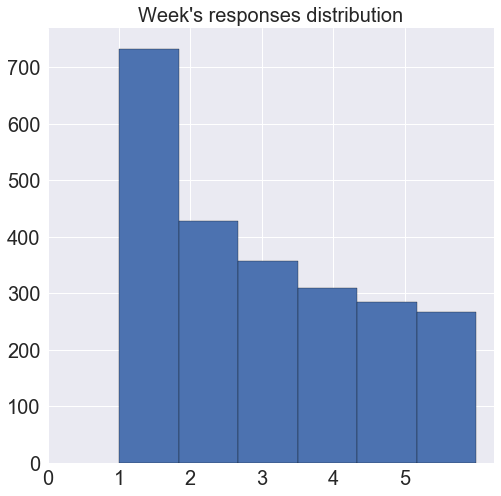

In [25]:
set_size()
plt.subplots(figsize=(8,8))
ref['week'].hist(bins=ref['week'].max(),edgecolor='black')
plt.xticks(list(range(0,ref['week'].max())))
plt.title("Week's responses distribution")
plt.show()

In [259]:
def plot_topic(row, vocabulary, topics, nbTopics, n_terms, nbColsPlot, n):
    MAGIC_NUMBER = 50
    fontsize_init = MAGIC_NUMBER
    fig = plt.figure(figsize=(15, 7))
    for topic in range(row, min(row + nbColsPlot, nbTopics)):

        plt.subplot(1, nbColsPlot, topic%nbColsPlot + 1)
        plt.ylim(0, n_terms + .5)
        plt.xticks([]) 
        plt.yticks([])
        plt.title('Topic #{}'.format(topic), fontsize=30)
        top_index = topics[topic].argsort()[:-n_terms - 1:-1]
        scores = topics[topic][top_index]
        words_topic = []
        max_topic_score = max(scores)
        for ind in range(len(top_index)):
            font_size = fontsize_init*scores[ind]/max_topic_score
            font_size = min(font_size, MAGIC_NUMBER)
            font_size = max(font_size, 20)
            words_topic.append(vocabulary[top_index[ind]])
            #if (all(ord(char) < 128 for char in vocabulary[ind])):
            plt.text(0.05, n_terms-ind-0.5, vocabulary[top_index[ind]], fontsize=font_size) 
        
        #plt.title(find_concept_of_topic(words_topic, n).upper(), color = 'blue', fontsize=30)
    
    
    plt.tight_layout()
    plt.show()

def plot_topics(model, vocab, nbTopics, n, n_terms=10, nbColsPlot=4):
    vocabulary = vocab
    topics = model.components_
    for row in range(0, nbTopics, nbColsPlot):
        plot_topic(row, vocabulary, topics, nbTopics, n_terms, nbColsPlot, n)



In [447]:
ref.head()

week                                          responses language  \
0     1  [The WISE simulations allowed the students to ...       en   
1     1  [The most effective aspects in wise activity w...       en   
2     1  [WISE uses predict-observe-explain patterns wi...       en   
3     1  [It appears that the interactive app allowed t...       en   
4     1  [Students can make predictions and test them. ...       en   

                              standardized_responses  \
0  [the wise simulations allowed the students to ...   
1  [the most effective aspects in wise activity w...   
2  [wise uses predict observe explain patterns wi...   
3  [it appears that the interactive app allowed t...   
4  [students can make predictions and test them. ...   

                                 processed_responses  nb_responses  
0  [wise simulation allow student conceptualize a...             2  
1  [effective aspect wise activity create spirit ...             2  
2  [wise use predict observe explain pattern prom...             2  
3  [appear interactive app allow visualize scienc...             2  
4  [student make prediction test work small group...             2

## 2.2) Perform LDA and NMF

<a id='2.2'></a>

In [449]:
"""
    Latent Dirichlet Allocation
"""

def LDA(df, week, questionNb, nbTopic, n):
    """
        df: dataframe contains documents/sentences
        week: which week that you want ?
        questionNb: which question in this week ?
        nbTopic: how many topics do you think these document have ?
        n: find top n sentences contribute for each topic
    """
    
    print('Welcome to LDA algorithm.')
    print('Begin find topics for all answers of question number {i} of week {w}'.format(i=questionNb, w=week))
    
    df = df[df['week']==week]
    
    df['relevant'] = df['processed_responses'].apply(lambda x : x[questionNb-1] if len(x) > questionNb-1 else '')
    " LDA can only use raw term counts for LDA because it is a probabilistic graphical model"
    
    df = df.reset_index().drop('index', 1)
    
    tf_vectorizer = CountVectorizer(min_df = 7, max_df = 18)
    tf = tf_vectorizer.fit_transform(df['relevant'])
    tf_feature_names = tf_vectorizer.get_feature_names()
    
    print('Shape of tfidf matrix:', tf.shape)
    
    "LDA"
    lda = LatentDirichletAllocation(n_topics=nbTopic, max_iter=50, learning_method='online', learning_offset=50.,random_state=nbTopic*50).fit(tf)

    print('Topic words distribution shape:', lda.components_.shape)
    plot_topics(lda, tf_feature_names, nbTopic, n)
    
    sim_matrix = concepts_responses_similarity(lda.components_, tf.toarray())
    
    "Retrieve top n sentences for a specific topic"
    d = {}
    for i in range(nbTopic):
        sentence_scores = sim_matrix[:,i]
        top_indexes = sentence_scores.argsort()[-n:][::-1]
        top_sentences = []
        for index in top_indexes:
            top_sentences.append(df.iloc[index]['standardized_responses'])
        d['Topic #'+str(i)] = top_sentences
    
    return df, pd.DataFrame.from_dict(d), lda.transform(tf)

In [458]:
"""
    Non-negative Matrix Factorization
"""

def nmf(df, week, questionNb, nbTopic, n):
    """
        df: dataframe contains documents/sentences
        week: which week that you want ?
        questionNb: which question in this week ?
        nbTopic: how many topics do you think these document have ?
        n: find top n sentences contribute for each topic
    """
    
    
    print('Welcome to NMF algorithm.')
    print('Begin find topics for all answers of question number {i} of week {w}'.format(i=questionNb, w=week))
    
    df = df[df['week']==week]
    
    df['relevant'] = df['processed_responses'].apply(lambda x : x[questionNb-1] if len(x) > questionNb-1 else '')
    
    df = df.reset_index().drop('index', 1)
    
    " Non-negative Matrix Factorization is able to use tf-idf "
    
    tfidf_vectorizer = TfidfVectorizer(min_df = 7, max_df = 18)#(max_features=vocab_size)
    tfidf = tfidf_vectorizer.fit_transform(df['relevant'])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    print('Shape of tfidf matrix:', tfidf.shape)
    
    "NMF"
    nmf = NMF(n_components=nbTopic, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
    
    print('Topic words distribution shape:', nmf.components_.shape)
    plot_topics(nmf, tfidf_feature_names, nbTopic, n)
    
    sim_matrix = concepts_responses_similarity(nmf.components_, tfidf.toarray())
    
    "Retrieve top n sentences for a specific topic"
    d = {}
    for i in range(nbTopic):
        sentence_scores = sim_matrix[:,i]
        top_indexes = sentence_scores.argsort()[-n:][::-1]
        top_sentences = []
        for index in top_indexes:
            top_sentences.append(df.iloc[index]['standardized_responses'])
        d['Topic #'+str(i)] = top_sentences
    
    
    return df, pd.DataFrame.from_dict(d), nmf.transform(tfidf)

In [451]:
def similarity(vec1, vec2):
    """
        Similarity between 2 vector
    """
    result = np.dot(vec1, vec2) / np.sqrt(np.sum(vec1 ** 2) * np.sum(vec2 ** 2))
    if (np.isnan(result)) : 
        result = 0
    return result

def concepts_responses_similarity(lda, tfidf):
    """
        Return a similarity matrix:
            - Row : reponses
            - Col : topics
    """
    nbSentences, nbFeature = tfidf.shape
    nbTopics, nbFeature = lda.shape
    result = np.zeros((nbSentences,nbTopics))
    for i in range(nbSentences):
        for j in range(nbTopics):
            result[i,j] = similarity(tfidf[i],lda[j])
    
    return result

In [463]:
"""
    Top nbTerm-responses with the highest similarity with topic topic_number
"""

def print_top_sentences_for_topic(df, topic_number, nbTerm):
    print('Top', nbTerm ,"sentences that contribute for Topic #{v}".format(v=topic_number))
    print('***************')
    print('***************')
    print('***************')
    column = 'Topic #' + str(topic_number)
    for i in range(nbTerm):
        print(df.iloc[i][column])
        print('--------------------------------------------------')

"""
    Find which topics have the most contribution for a specific response
"""
def print_top_topics_for_sentence(topicsSent, responseID, n):
    show = "Response "+str(responseID)+": "
    sentence = topicsSent[responseID,:]
    top_indexes = sentence.argsort()[::-1][:n]
    for idx, i in enumerate(top_indexes):
        show += str(sentence[i])[:4] + '*Topic' + str(i)
        if (idx != n - 1):
            show += ' + '
    print(show)

Welcome to LDA algorithm.
Begin find topics for all answers of question number 1 of week 1
Shape of tfidf matrix: (733, 228)
Topic words distribution shape: (8, 228)


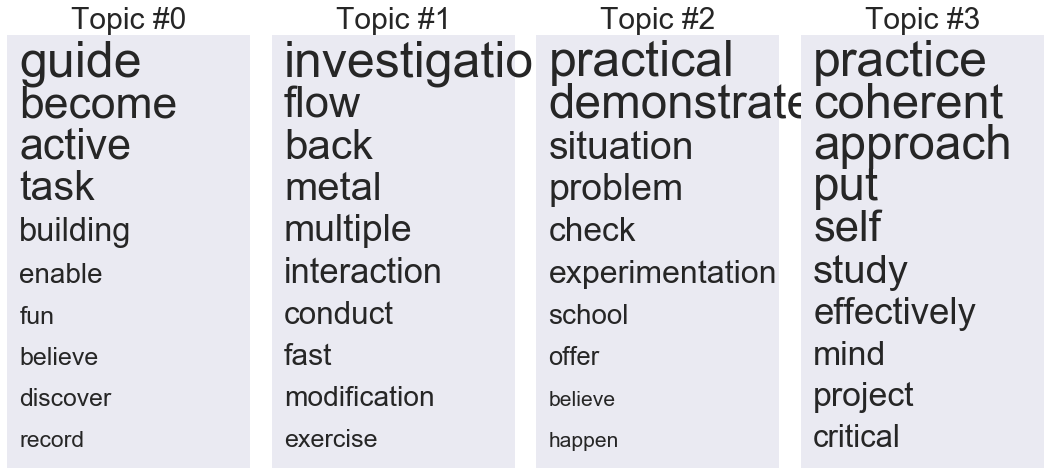

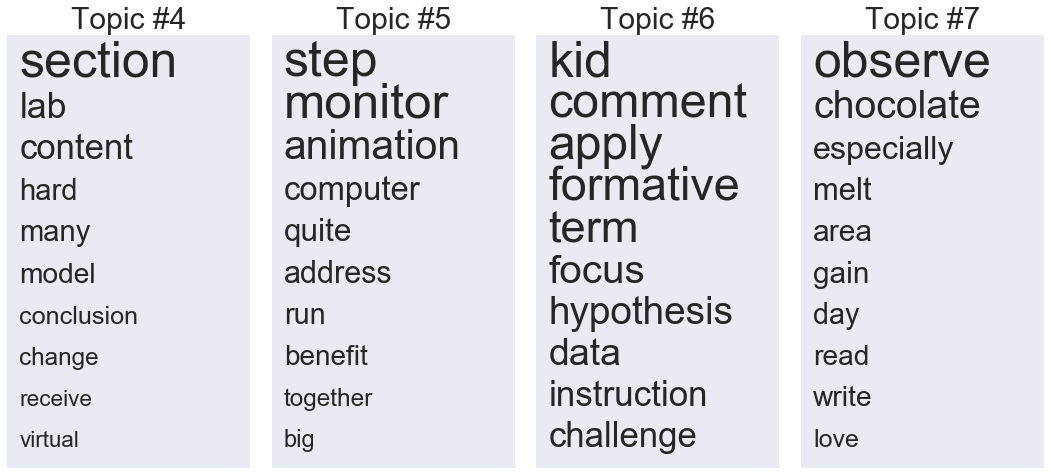

In [453]:
df_lda, sentsTopic_lda, topicsSent_lda = LDA(df = ref, week = 1, questionNb = 1, nbTopic = 8, n = 20)

Welcome to NMF algorithm.
Begin find topics for all answers of question number 1 of week 1
Shape of tfidf matrix: (733, 228)
Topic words distribution shape: (8, 228)


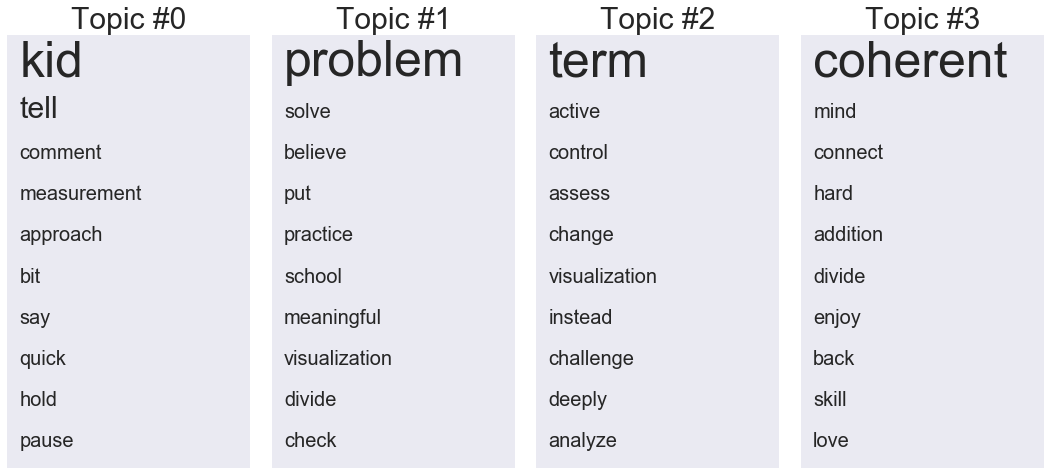

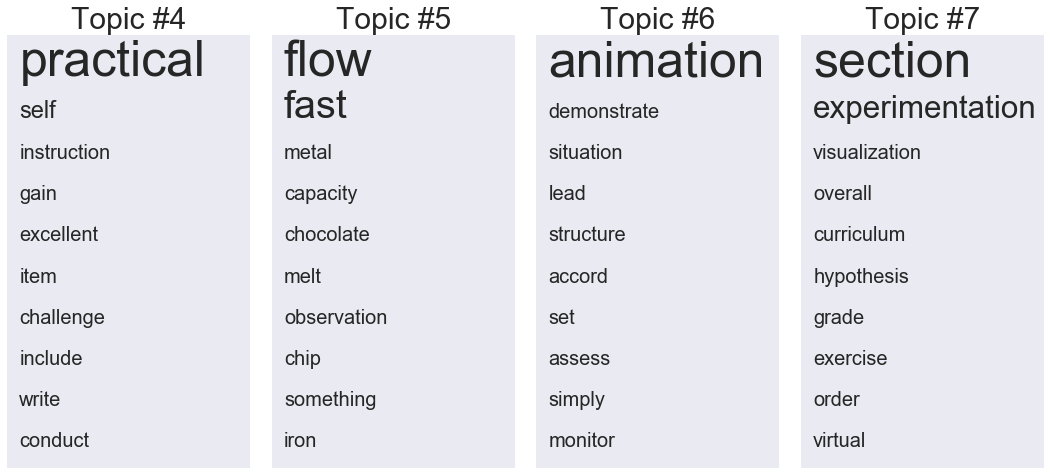

In [460]:
df_nmf ,sentsTopic_nmf, topicsSent_nmf = nmf(df=ref, week=1, questionNb = 1, nbTopic=8, n=20)

In [320]:
"""
    Top 20 responses with the highest similarity with topic 7
"""

print_top_sentences_for_topic(sentsTopic_lda, 7, 20)

Top 20 sentences that contribute for Topic #7
***************
***************
***************
['i think the area where students explored in melting chocolate chips and touching an iron with different bars made of glass and metal really gave a huge understanding to the students. ', "jennifer's role during the lesson was to check students understanding and guide them correctly by discussing the subject matter with the students. the new opportunities that comes as a result of using wise is the teacher was able to detect when the students were getting stuck and how she can be of help to them. it makes it easy for the teacher to get her own copy of any lesson. it also help the teacher to develop some great ideas on how to run the activity next time maybe by modifying her lessons  planning for more activities  or asking different questions."]
--------------------------------------------------
['i thought the simulation was very helpful  and i also felt the hands on  especially melting the ch

In [464]:
"""
    Find which topics have the most contribution for a specific response
"""

for responseID in range (30):
    print_top_topics_for_sentence(topicsSent_lda, responseID, 3)

Response 0: 0.93*Topic7 + 0.00*Topic0 + 0.00*Topic6
Response 1: 0.56*Topic1 + 0.06*Topic4 + 0.06*Topic7
Response 2: 0.56*Topic7 + 0.06*Topic4 + 0.06*Topic5
Response 3: 0.56*Topic6 + 0.06*Topic4 + 0.06*Topic3
Response 4: 0.12*Topic7 + 0.12*Topic6 + 0.12*Topic5
Response 5: 0.92*Topic6 + 0.01*Topic1 + 0.01*Topic5
Response 6: 0.78*Topic4 + 0.03*Topic7 + 0.03*Topic1
Response 7: 0.46*Topic4 + 0.28*Topic2 + 0.04*Topic3
Response 8: 0.65*Topic5 + 0.23*Topic6 + 0.01*Topic1
Response 9: 0.39*Topic5 + 0.35*Topic7 + 0.04*Topic0
Response 10: 0.56*Topic0 + 0.06*Topic7 + 0.06*Topic5
Response 11: 0.56*Topic6 + 0.06*Topic0 + 0.06*Topic3
Response 12: 0.68*Topic4 + 0.18*Topic1 + 0.02*Topic7
Response 13: 0.70*Topic4 + 0.04*Topic7 + 0.04*Topic5
Response 14: 0.91*Topic6 + 0.01*Topic1 + 0.01*Topic2
Response 15: 0.70*Topic0 + 0.04*Topic1 + 0.04*Topic4
Response 16: 0.53*Topic4 + 0.28*Topic0 + 0.03*Topic6
Response 17: 0.82*Topic7 + 0.02*Topic1 + 0.02*Topic3
Response 18: 0.56*Topic2 + 0.06*Topic4 + 0.06*Topic5
Res

## 2.3) Visualization
<a id='2.3'></a>

In [292]:
def sentent2vec(sentence):
    count = 0
    initVec = np.array([0.0]*300)
    
    for word in sentence.split():
        if word in fasttext:
            initVec += fasttext[word]
            count += 1
    return initVec / count if count > 0 else initVec

In [299]:
def avg_word2vec(df, week, questionNb):
    
    count = 0
    initVec = np.array([0.0]*300)
    
    df['avg_word2vec'] = df['relevant'].apply(sentent2vec)
    
    return df

In [194]:
from sklearn.decomposition import PCA

In [302]:
def sentence_visualization_1(df, week, questionNb, nbTopics):
        
    "Data preparation for clustering"
    vocab = np.array(df['responses'])
    df = df[df['week']==week]
    df['relevant'] = df['processed_responses'].apply(lambda x : x[questionNb-1] if len(x) > questionNb-1 else '')
    
    df = df.reset_index().drop('index', 1)
    df = avg_word2vec(df, week, questionNb)
    X = []
    for x in df['avg_word2vec']:
        X.append(list(x))

    "TSNE Algorithm"
    TSNE_X = tsne(perplexity=45, X=X) 
    
    #"PCA"
    #pca = PCA(n_components=2).fit_transform(X)
    
    "Run k-means"

    labels_tsne, centers_tsne, clusters_tsne = \
                                k_means(nbTopics, TSNE_X, vocab, 200)
    
    "Bokeh visualization"
    bokeh_visualization(TSNE_X, vocab, labels_tsne, k=nbTopics)
    
    return df, labels_tsne, centers_tsne, clusters_tsne

In [305]:
df_3, labels_tsne, centers_tsne, clusters_tsne = sentence_visualization_1(ref, week = 1 , questionNb = 1,  nbTopics = 8)

Loading BokehJS ...

Loading BokehJS ...

# 3) Hypothesis dataset
<a id='3'></a>

In [224]:
hyp = pd.read_csv('data/hypothesis.tsv', header = None, sep = '\t', encoding = "ISO-8859-1")
hyp.columns = ['original', 'annotated', 'source']
hyp.dropna(inplace=True)
hyp = hyp.reset_index().drop('index', 1)
hyp.head(7)

original  \
0  This is a great example of Kohonen's Self-orga...   
1                                     Data Structure   
2  I really like this concept and application of ...   
3  These are important questions that need answer...   
4  I am familiar with SPSS, but I had not conside...   
5  I am interested in learning more about the Net...   
6  I need to more practice with creating cleaner ...   

                                           annotated  \
0  Appendix. Technical demonstration of the SOMpr...   
1  The SOM consisted of 360 neurons on a 24by  15...   
2  Ryu, S., & Lombardi, D. (2015). Coding Classro...   
3    address the questions in the previous paragraph   
4  analyses using these ego-level measures can be...   
5  UCINET is NetDraw, a visualization tool that h...   
6  visualizing your network in the form of a grap...   

                                              source  
0                     doi:10.1016/j.ejor.2006.06.006  
1                     doi:10.1016/j.ejor.2006.06.006  
2               Social Network Analysis in Education  
3  An Introduction to Statistical Inference With ...  
4  Looking Back, Looking Ahead - SAGE Research Me...  
5  Looking Back, Looking Ahead - SAGE Research Me...  
6  Looking Back, Looking Ahead - SAGE Research Me...